In [2]:
import pandas as pd
import numpy as np
import os
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from scipy.signal import find_peaks, detrend
import pywt

from numpy import arange, array, linspace, loadtxt, log2, logspace, mean, polyfit
from numpy import zeros, pi, sin, cos, arctan2, sqrt, real, imag, conj, tile
from numpy import round, interp, diff, unique, where
from pandas import DataFrame, date_range
import matplotlib.dates as mdates
from matplotlib import pyplot
from scipy.stats import pearsonr, mannwhitneyu, kruskal, norm
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GroupKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,f1_score, recall_score, precision_score,roc_auc_score, roc_curve, auc,accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from collections import defaultdict, Counter


import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,Concatenate,Input,Dropout, Conv2D, MaxPooling2D, Flatten,Multiply,Attention,Dense,concatenate,Masking,BatchNormalization, Reshape
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications import DenseNet121
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History
history = History()

import pickle
import joblib
import dill
import json
from collections import defaultdict
from scipy.signal import savgol_filter
import gc
import warnings
warnings.filterwarnings('ignore')


In [3]:
import tensorflow as tf

# List all available GPUs
gpus = tf.config.list_physical_devices('GPU')

# Set the visible devices
try:
    tf.config.set_visible_devices(gpus[1], 'GPU')  # Adjust indices as needed
    # tf.config.set_visible_devices(gpus[7], 'GPU')  # Adjust indices as needed
except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [4]:

def remove_nan_rows(X_daily, X_individual, y_label):
    # Find rows with NaNs in either feature vector
    nan_mask_daily = np.any(np.isnan(X_daily), axis=(1, 2))
    nan_mask_individual = np.any(np.isnan(X_individual), axis=(1, 2))
    
    nan_mask_combined = nan_mask_daily | nan_mask_individual    
    # Keep only rows without NaNs
    X_daily_clean = X_daily[~nan_mask_combined]
    X_individual_clean = X_individual[~nan_mask_combined]
    y_label_clean = y_label[~nan_mask_combined]
    return X_daily_clean, X_individual_clean, y_label_clean

def apply_smote_resampling(X_matrices, X_features_daily, X_features_individual, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)

    # Combine all inputs into a single 2D array for SMOTE
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*3),
        X_features_daily,
        X_features_individual
    ])

    # Apply SMOTE to the combined array and the target
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    # Extract the resampled components
    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*3].reshape(-1, matrix_shape0, 288, 3)
    start = matrix_shape0 * 288*3
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:]
    
    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            y_resampled)

def apply_smote_resampling_mask(X_matrices, X_features_daily, X_features_individual, mask_daily, mask_individual, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*3),
        X_features_daily,
        X_features_individual,
        mask_daily,
        mask_individual
    ])
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*3].reshape(-1, matrix_shape0, 288, 3)
    start = matrix_shape0 * 288*3
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:start + X_features_individual.shape[1]]
    start += X_features_individual.shape[1]
    mask_daily_resampled = X_resampled_combined[:, start:start + mask_daily.shape[1]]
    start += mask_daily.shape[1]
    mask_individual_resampled = X_resampled_combined[:, start:]

    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            mask_daily_resampled, 
            mask_individual_resampled, 
            y_resampled)
def apply_smote_resampling_mask_2d(X_matrices, X_features_daily, X_features_individual, mask_daily, mask_individual, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*2),
        X_features_daily,
        X_features_individual,
        mask_daily,
        mask_individual
    ])
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*2].reshape(-1, matrix_shape0, 288, 2)
    start = matrix_shape0 * 288*2
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:start + X_features_individual.shape[1]]
    start += X_features_individual.shape[1]
    mask_daily_resampled = X_resampled_combined[:, start:start + mask_daily.shape[1]]
    start += mask_daily.shape[1]
    mask_individual_resampled = X_resampled_combined[:, start:]

    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            mask_daily_resampled, 
            mask_individual_resampled, 
            y_resampled)
def apply_smote_resampling_mask_1d(X_matrices, X_features_daily, X_features_individual, mask_daily, mask_individual, y, matrix_shape0=288):
    smote = SMOTE(random_state=42)
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*1),
        X_features_daily,
        X_features_individual,
        mask_daily,
        mask_individual
    ])
    X_resampled_combined, y_resampled = smote.fit_resample(X_combined, y)

    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*1].reshape(-1, matrix_shape0, 288, 1)
    start = matrix_shape0 * 288*1
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:start + X_features_individual.shape[1]]
    start += X_features_individual.shape[1]
    mask_daily_resampled = X_resampled_combined[:, start:start + mask_daily.shape[1]]
    start += mask_daily.shape[1]
    mask_individual_resampled = X_resampled_combined[:, start:]

    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            mask_daily_resampled, 
            mask_individual_resampled, 
            y_resampled)
    
def apply_SMOTEENN_resampling_mask(X_matrices, X_features_daily, X_features_individual, mask_daily, mask_individual, y, matrix_shape0=288):
    smoteenn = SMOTEENN(random_state=42)
    X_combined = np.hstack([
        X_matrices.reshape(-1, matrix_shape0 * 288*3),
        X_features_daily,
        X_features_individual,
        mask_daily,
        mask_individual
    ])
    X_resampled_combined, y_resampled = smoteenn.fit_resample(X_combined, y)

    X_matrices_resampled = X_resampled_combined[:, :matrix_shape0 * 288*3].reshape(-1, matrix_shape0, 288, 3)
    start = matrix_shape0 * 288*3
    X_features_daily_resampled = X_resampled_combined[:, start:start + X_features_daily.shape[1]]
    start += X_features_daily.shape[1]
    X_features_individual_resampled = X_resampled_combined[:, start:start + X_features_individual.shape[1]]
    start += X_features_individual.shape[1]
    mask_daily_resampled = X_resampled_combined[:, start:start + mask_daily.shape[1]]
    start += mask_daily.shape[1]
    mask_individual_resampled = X_resampled_combined[:, start:]

    return (X_matrices_resampled, 
            X_features_daily_resampled, 
            X_features_individual_resampled, 
            mask_daily_resampled, 
            mask_individual_resampled, 
            y_resampled)


In [5]:
with open('/mnt/data1/ma98/data_generated/dict_3d_cgm_mex_morl_original_70_15min.dill', 'rb') as f:
    loaded_dict = dill.load(f)
    
data_dict = loaded_dict.copy()


In [6]:
filtered_data_dict = {}
for participant_id, days_data in data_dict.items():
    filtered_days_data = []
    for current_date, day_data in days_data.items():

        if (day_data['len_original_cgm'] > 252 and np.sum(day_data['CGM_stats_daily_original'].isna()).sum()<1):
            filtered_days_data.append(day_data)
    
    if filtered_days_data:
        filtered_data_dict[participant_id] = filtered_days_data

print(len(data_dict),len(filtered_data_dict))


491 491


In [12]:
# Prepare the groups based on participant IDs
participant_ids = []
X_features_individual, X_features_daily = [], []
X_features_individual_cgm, X_features_daily_cgm = [], []
X_matrices_power, X_matrices_coeffs = [], []
y_labels = { 
    "hypo_early_night": [], "hypo_night": [], "hypo_long_night": [],
    "hypo_night_morning": [], "hyper_day": [], "hypo_late_night": [],
    "hyper_night": [], "hyper_early_night": [], "hypo_morning": [],
    "hypo_day": []
}

for participant_id, days_data in filtered_data_dict.items():
    participant_ids.extend([participant_id] * len(days_data))
    for day_data in days_data:
        X_matrices_power.append(day_data['full_matrix_cgm_power'])
        X_matrices_coeffs.append(day_data['full_matrix_cgm_coeffs'])
        X_features_daily_cgm.append(day_data['CGM_stats_daily'])
        X_features_individual_cgm.append(day_data['CGM_stats_participant'])
        X_features_daily.append(np.concatenate([
            day_data['CGM_stats_daily_original'],
            day_data['Basal_stats_daily'],
            day_data['Carbs_stats_daily'],
            day_data['HR_stats_daily']], axis=1))
        X_features_individual.append(np.concatenate([
            [[day_data['A1c']]],
            [[day_data['Weight']]],
            [[day_data['Height']]],
            day_data['CGM_stats_participant'],
            day_data['Basal_stats_participant'],
            day_data['HR_stats_participant']], axis=1))
        
        # Store labels in the dictionary
        for label in y_labels.keys():
            y_labels[label].append(day_data['next_day_cgm_labels_original'][label])
    
participant_ids = np.array(participant_ids)
X_matrices_power = np.array(X_matrices_power)
X_matrices_coeffs = np.array(X_matrices_coeffs)
X_features_daily = np.array(X_features_daily)
X_features_individual = np.array(X_features_individual)
X_features_daily_cgm = np.array(X_features_daily_cgm)
X_features_individual_cgm = np.array(X_features_individual_cgm)

# Convert labels to NumPy arrays
for key in y_labels:
    y_labels[key] = np.array(y_labels[key], dtype=np.float32)

# Normalize the individual features
def standard_scale(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data.reshape(-1, data.shape[-1]))

# Apply vectorized scaling
X_features_individual_scaled = standard_scale(X_features_individual)
X_features_daily_scaled = standard_scale(X_features_daily)
X_features_individual_cgm_scaled = standard_scale(X_features_individual_cgm)
X_features_daily_cgm_scaled = standard_scale(X_features_daily_cgm)

def check_nans(arr, name):
    print(f"{name}: {np.isnan(arr).sum()}  NaNs with shape: {arr.shape}")

print('NaNs in the Data ...')
check_nans(X_matrices_power, "X_matrices_power")
check_nans(X_matrices_coeffs, "X_matrices_coeffs")
check_nans(X_features_daily, "X_features_daily")
check_nans(X_features_individual, "X_features_individual")
check_nans(X_features_daily_cgm, "X_features_daily_cgm")
check_nans(X_features_individual_cgm, "X_features_individual_cgm")
for key in y_labels:
    check_nans(y_labels[key], f"y_label {key}")


NaNs in the Data ...
X_matrices_power: 0  NaNs with shape: (10702, 288, 288, 3)
X_matrices_coeffs: 0  NaNs with shape: (10702, 288, 288, 3)
X_features_daily: 385521  NaNs with shape: (10702, 1, 326)
X_features_individual: 70296  NaNs with shape: (10702, 1, 294)
X_features_daily_cgm: 0  NaNs with shape: (10702, 1, 136)
X_features_individual_cgm: 0  NaNs with shape: (10702, 1, 141)
y_label hypo_early_night: 0  NaNs with shape: (10702, 1)
y_label hypo_night: 0  NaNs with shape: (10702, 1)
y_label hypo_long_night: 0  NaNs with shape: (10702, 1)
y_label hypo_night_morning: 0  NaNs with shape: (10702, 1)
y_label hyper_day: 0  NaNs with shape: (10702, 1)
y_label hypo_late_night: 0  NaNs with shape: (10702, 1)
y_label hyper_night: 0  NaNs with shape: (10702, 1)
y_label hyper_early_night: 0  NaNs with shape: (10702, 1)
y_label hypo_morning: 0  NaNs with shape: (10702, 1)
y_label hypo_day: 0  NaNs with shape: (10702, 1)


In [13]:
def manual_standard_scaling(matrix):
    # mean = np.nanmean(matrix)
    std = np.nanstd(matrix)
    scaled_matrix = matrix / std
    return scaled_matrix
    
X_matrices_power_scaled = np.zeros_like(X_matrices_power)
for i in range(X_matrices_power.shape[0]):
    matrix_coefficients_scaled = manual_standard_scaling(X_matrices_power[i, :, :, 0])
    X_matrices_power_scaled[i, :, :, 0] = matrix_coefficients_scaled
    
    matrix_power_scaled = manual_standard_scaling(X_matrices_power[i, :, :, 1])
    X_matrices_power_scaled[i, :, :, 1] = matrix_power_scaled
    matrix_power_scaled = manual_standard_scaling(X_matrices_power[i, :, :, 2])
    X_matrices_power_scaled[i, :, :, 2] = matrix_power_scaled
    
X_matrices_coeffs_scaled = np.zeros_like(X_matrices_coeffs)
for i in range(X_matrices_coeffs.shape[0]):
    matrix_coefficients_scaled = manual_standard_scaling(X_matrices_coeffs[i, :, :, 0])
    X_matrices_coeffs_scaled[i, :, :, 0] = matrix_coefficients_scaled
    
    matrix_power_scaled = manual_standard_scaling(X_matrices_coeffs[i, :, :, 1])
    X_matrices_coeffs_scaled[i, :, :, 1] = matrix_power_scaled
    matrix_power_scaled = manual_standard_scaling(X_matrices_coeffs[i, :, :, 2])
    X_matrices_coeffs_scaled[i, :, :, 2] = matrix_power_scaled
    
X_matrices_power_scaled[0,:,:,2]

array([[2.07285298e-06, 1.09657967e-04, 1.49772296e-04, ...,
        2.34176964e-05, 5.28250211e-05, 1.95310295e-04],
       [2.50270754e-03, 3.17086616e-03, 9.22433324e-05, ...,
        3.66439113e-03, 1.30995087e-02, 1.30063819e-02],
       [1.55885471e-02, 2.09501266e-03, 1.45394958e-03, ...,
        7.26925644e-03, 2.63986305e-03, 3.72076772e-05],
       ...,
       [1.42963757e-05, 2.65158540e-04, 6.26985951e-04, ...,
        1.89597705e-04, 2.37221582e-03, 2.15363007e-03],
       [5.62506759e-03, 8.67475687e-03, 8.48445730e-03, ...,
        2.01446124e-03, 6.29517492e-03, 9.75784029e-03],
       [2.32378114e-03, 4.64502720e-03, 4.15342970e-03, ...,
        1.69490564e-05, 1.54745031e-04, 6.26550838e-04]])

In [14]:
# Remove the first channel and keep only channels 1 and 2
X_power_mex_morl = X_matrices_power_scaled[:, :, :, 1:]  
X_coeffs_mex_power_morl = X_matrices_power_scaled[:, :, :, [0,2]]  
X_coeffs_power_mex = X_matrices_power_scaled[:, :, :, :2]  
X_coeffs_morl = X_matrices_coeffs_scaled[:, :, :, 0]  
X_coeffs_mex = X_matrices_power_scaled[:, :, :, 0]  
X_power_mex = X_matrices_power_scaled[:, :, :, :1]  
X_power_morl = X_matrices_power_scaled[:, :, :, 2]  

# Check the new shape
print(X_coeffs_mex.shape)  # Should output (10707, 288, 288, 2)


(10702, 288, 288)


In [15]:
# Attention mechanism
def attention_block(x):
    attention = Conv2D(32, kernel_size=(1, 1), activation='relu')(x)
    attention = BatchNormalization()(attention)
    attention = GlobalMaxPooling2D()(attention)
    attention = Dense(x.shape[-1], activation='sigmoid')(attention)
    attention = Reshape((1, 1, x.shape[-1]))(attention)
    attention = Multiply()([x, attention])
    return attention
def create_model():
    # Define the CNN Model
    input_matrix = Input(shape=(matrix_shape0, 288, 3), name='input_matrix')
    input_features_daily = Input(shape=(X_features_daily_scaled.shape[1],), name='input_features_daily')
    input_features_individual = Input(shape=(X_features_individual_scaled.shape[1],), name='input_features_individual')
    input_mask_daily = Input(shape=(X_features_daily_scaled.shape[1],), name='input_mask_daily')
    input_mask_individual = Input(shape=(X_features_individual_scaled.shape[1],), name='input_mask_individual')
    
    conv1 = Conv2D(32, kernel_size=(5, 5), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(input_matrix)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv1 = attention_block(conv1)  # Add attention here
    # conv1 = Dropout(0.2)(conv1)

    conv2 = Conv2D(64, kernel_size=(3, 3), dilation_rate=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # conv2 = Dropout(0.2)(conv2)

    # Convolution Block 3 with Spatial Pyramid Pooling
    conv3 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', kernel_regularizer=l2(0.001))(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten and concatenate with feature vectors
    flat = Flatten()(conv3)
    dense_flat = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(flat)
    attention_flat = Dense(1024, activation='softmax')(dense_flat)
    attention_flat = Multiply()([dense_flat, attention_flat])

    densed_fully = Dense(512, activation='relu')(attention_flat)
    densed_fully = Dropout(0.5)(densed_fully)

    # Masked dense layers for the daily features
    masked_daily = Multiply()([input_features_daily, input_mask_daily])  # Apply mask to daily features
    dense_daily = Dense(128, activation='relu')(masked_daily)
    
    # Masked dense layers for the individual features
    masked_individual = Multiply()([input_features_individual, input_mask_individual])
    dense_individual = Dense(128, activation='relu')(masked_individual)
    
    # Combine feature inputs
    concat_features = concatenate([dense_daily, dense_individual])
    
    # Cross-Attention mechanism to extract relevant parts of both feature vectors
    attention_weights = Dense(256, activation='softmax')(concat_features)
    attention_features = Multiply()([concat_features, attention_weights])
    
    # Combine all inputs
    concat_all = concatenate([densed_fully, attention_features])
    
    fc_combined = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(concat_all)
    fc_combined = Dropout(0.6)(fc_combined)

    attention_fc_combined = Dense(256, activation='relu')(fc_combined)
    attention_fc_combined = Dropout(0.7)(attention_fc_combined)
    
    fc_additional = Dense(128, activation='relu')(attention_fc_combined)
    output = Dense(1, activation='sigmoid', dtype='float32')(fc_additional)
    model = Model(inputs=[input_matrix, input_features_daily, input_features_individual, input_mask_daily, input_mask_individual], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model
import gc
gc.collect()



2368

Processing fold 1...
351, 69, 46, participants in Train, Validation, and Test sets


2024-10-01 21:19:03.959681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78973 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:2a:00.0, compute capability: 8.0
2024-10-01 21:19:06.242194: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-01 21:19:06.242228: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-01 21:19:06.242253: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is k

Epoch 1/35


2024-10-01 21:19:48.997516: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fab3c008220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-01 21:19:48.997608: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-10-01 21:19:49.605381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 21:19:59.591210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-10-01 21:20:07.253007: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-01 21:20:07.256644: W tensorflow/compiler/xla/stream_executor/gpu/re

426/429 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.7726 - accuracy: 0.6853 - loss: 2.3265



2024-10-01 21:20:28.450225: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.7731 - accuracy: 0.6859 - loss: 2.3226



2024-10-01 21:20:36.469777: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2024-10-01 21:20:38.271427: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



429/429 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step - AUC: 0.7733 - accuracy: 0.6861 - loss: 2.3213 - val_AUC: 0.6473 - val_accuracy: 0.6476 - val_loss: 1.5179 - learning_rate: 1.0000e-04
Epoch 2/35
429/429 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 0.9377 - accuracy: 0.8767 - loss: 0.8907 - val_AUC: 0.9547 - val_accuracy: 0.8949 - val_loss: 0.7076 - learning_rate: 1.0000e-04
Epoch 3/35
429/429 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 0.9762 - accuracy: 0.9287 - loss: 0.5964 - val_AUC: 0.9598 - val_accuracy: 0.9010 - val_loss: 0.5967 - learning_rate: 1.0000e-04
Epoch 4/35
429/429 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 0.9833 - accuracy: 0.9429 - loss: 0.4771 - val_AUC: 0.9620 - val_accuracy: 0.8834 - val_loss: 0.5871 - learning_rate: 1.0000e-04
Epoch 5/35
429/429 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 0.9901 - accuracy: 0.9545 - loss: 0.3839 - val_AUC: 0.9581 - val_accuracy: 0.9037 - val_loss: 0.5263 - learning_rate: 1.0000e-04
Epoch 6/35
429/429 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 0.



2024-10-01 21:24:07.498453: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.3382778465747833, Train accuracy: 0.9654569029808044
Validation loss: 0.5263001322746277, Validation accuracy: 0.9036697149276733




2024-10-01 21:24:27.299820: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



2024-10-01 21:24:30.885198: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



2024-10-01 21:24:33.622984: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Test ROC AUC: 0.8860
Test Accuracy: 0.8168
Test MAE: 0.1589
Test Percision: 0.4138
Test Specificity: 0.8241
Test Sensitivity(Recall): 0.7714
Test F1: 0.5387 

Fold 1 - AUC: 0.8860, Accuracy: 0.8168, Recall: 0.7714, Precision: 0.4138, Specificity: 0.8241, F1: 0.5387

[[717 153]
 [ 32 108]]
Processing fold 2...
349, 70, 47, participants in Train, Validation, and Test sets
Epoch 1/35




2024-10-01 21:37:38.001905: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



430/432 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.7206 - accuracy: 0.6452 - loss: 2.2917



2024-10-01 21:37:54.828908: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.7211 - accuracy: 0.6457 - loss: 2.2894





2024-10-01 21:38:07.295714: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



432/432 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - AUC: 0.7214 - accuracy: 0.6459 - loss: 2.2882 - val_AUC: 0.7873 - val_accuracy: 0.6715 - val_loss: 1.3363 - learning_rate: 1.0000e-04
Epoch 2/35
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 0.9392 - accuracy: 0.8780 - loss: 0.9648 - val_AUC: 0.9622 - val_accuracy: 0.8815 - val_loss: 0.7602 - learning_rate: 1.0000e-04
Epoch 3/35
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - AUC: 0.9746 - accuracy: 0.9263 - loss: 0.6493 - val_AUC: 0.9695 - val_accuracy: 0.9051 - val_loss: 0.5884 - learning_rate: 1.0000e-04
Epoch 4/35
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - AUC: 0.9837 - accuracy: 0.9400 - loss: 0.5001 - val_AUC: 0.9669 - val_accuracy: 0.9002 - val_loss: 0.5484 - learning_rate: 1.0000e-04
Epoch 5/35
432/432 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 0.9895 - accuracy: 0.9502 - loss: 0.4024 - val_AUC: 0.9638 - val_accuracy: 0.9077 - val_loss: 0.5063 - learning_rate: 1.0000e-04
Epoch 6/35
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - AUC: 0.993



2024-10-01 21:41:14.197115: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.2706405818462372, Train accuracy: 0.9720694422721863
Validation loss: 0.484682559967041, Validation accuracy: 0.9054558873176575


250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



2024-10-01 21:41:37.301032: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test ROC AUC: 0.8756
Test Accuracy: 0.7868
Test MAE: 0.1893
Test Percision: 0.4304
Test Specificity: 0.7887
Test Sensitivity(Recall): 0.7771
Test F1: 0.5540 

Fold 2 - AUC: 0.8756, Accuracy: 0.7868, Recall: 0.7771, Precision: 0.4304, Specificity: 0.7887, F1: 0.5540

[[672 180]
 [ 39 136]]
Processing fold 3...
349, 70, 47, participants in Train, Validation, and Test sets
Epoch 1/35




2024-10-01 21:44:34.917197: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



430/433 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.7647 - accuracy: 0.6840 - loss: 2.4463



2024-10-01 21:44:53.405978: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - AUC: 0.7652 - accuracy: 0.6846 - loss: 2.4428

433/433 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - AUC: 0.7654 - accuracy: 0.6847 - loss: 2.4416 - val_AUC: 0.8142 - val_accuracy: 0.6504 - val_loss: 1.4529 - learning_rate: 1.0000e-04
Epoch 2/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - AUC: 0.9389 - accuracy: 0.8807 - loss: 1.0531 - val_AUC: 0.9628 - val_accuracy: 0.9027 - val_loss: 0.7899 - learning_rate: 1.0000e-04
Epoch 3/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 0.9771 - accuracy: 0.9256 - loss: 0.6927 - val_AUC: 0.9703 - val_accuracy: 0.9016 - val_loss: 0.6172 - learning_rate: 1.0000e-04
Epoch 4/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 0.9856 - accuracy: 0.9435 - loss: 0.5251 - val_AUC: 0.9698 - val_accuracy: 0.9054 - val_loss: 0.5458 - learning_rate: 1.0000e-04
Epoch 5/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 0.9920 - accuracy: 0.9586 - loss: 0.4110 - val_AUC: 0.9633 - val_accuracy: 0.8872 - val_loss: 0.6305 - learning_rate: 1.0000e-04
Epoch 6/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 0



2024-10-01 21:48:27.809048: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.2844220697879791, Train accuracy: 0.9785621762275696
Validation loss: 0.46621665358543396, Validation accuracy: 0.9104651212692261


246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



2024-10-01 21:48:47.735971: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



2024-10-01 21:48:50.182189: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Test ROC AUC: 0.8738
Test Accuracy: 0.8428
Test MAE: 0.1503
Test Percision: 0.4867
Test Specificity: 0.8682
Test Sensitivity(Recall): 0.7006
Test F1: 0.5744 

Fold 3 - AUC: 0.8738, Accuracy: 0.8428, Recall: 0.7006, Precision: 0.4867, Specificity: 0.8682, F1: 0.5744

[[764 116]
 [ 47 110]]
Processing fold 4...
349, 70, 47, participants in Train, Validation, and Test sets
Epoch 1/35


430/433 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - AUC: 0.7483 - accuracy: 0.6611 - loss: 2.4296



2024-10-01 21:53:08.417216: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.7488 - accuracy: 0.6617 - loss: 2.4263





2024-10-01 21:53:15.810683: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



433/433 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - AUC: 0.7490 - accuracy: 0.6619 - loss: 2.4252 - val_AUC: 0.7502 - val_accuracy: 0.6625 - val_loss: 1.4446 - learning_rate: 1.0000e-04
Epoch 2/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 0.9395 - accuracy: 0.8853 - loss: 1.0367 - val_AUC: 0.9391 - val_accuracy: 0.8718 - val_loss: 0.7799 - learning_rate: 1.0000e-04
Epoch 3/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 0.9763 - accuracy: 0.9271 - loss: 0.6091 - val_AUC: 0.9476 - val_accuracy: 0.8776 - val_loss: 0.6090 - learning_rate: 1.0000e-04
Epoch 4/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 0.9851 - accuracy: 0.9433 - loss: 0.4469 - val_AUC: 0.9565 - val_accuracy: 0.8868 - val_loss: 0.5145 - learning_rate: 1.0000e-04
Epoch 5/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 0.9912 - accuracy: 0.9580 - loss: 0.3476 - val_AUC: 0.9457 - val_accuracy: 0.8871 - val_loss: 0.5377 - learning_rate: 1.0000e-04
Epoch 6/35
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 



2024-10-01 21:56:14.211553: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.3522334098815918, Train accuracy: 0.9610934257507324
Validation loss: 0.5144957304000854, Validation accuracy: 0.8867786526679993


247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


2024-10-01 21:56:39.471371: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



Test ROC AUC: 0.8487
Test Accuracy: 0.7888
Test MAE: 0.1823
Test Percision: 0.4144
Test Specificity: 0.8082
Test Sensitivity(Recall): 0.6899
Test F1: 0.5178 

Fold 4 - AUC: 0.8487, Accuracy: 0.7888, Recall: 0.6899, Precision: 0.4144, Specificity: 0.8082, F1: 0.5178

[[649 154]
 [ 49 109]]

Average Train Accuracy: 0.9693 (+- 0.0066)
Average Validation Accuracy: 0.9016 (+- 0.0089)
Average Test Accuracy: 0.8088 (+- 0.0230)
Average Test Recall: 0.7348 (+- 0.0397)
Average Test Precision: 0.4363 (+- 0.0298)
Average Test Specificity: 0.8223 (+- 0.0293)
Average Test AUC: 0.8710 (+- 0.0137)
Average Test F1: 0.5462 (+- 0.0207)


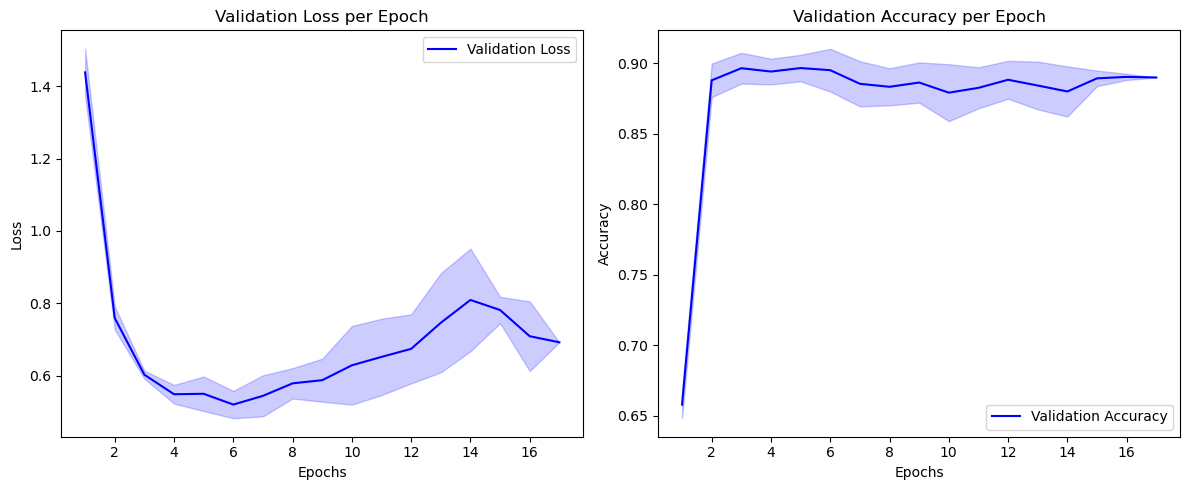

Aggregated Models on holdout set ... 

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



2024-10-01 21:56:43.047674: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Holdout ROC AUC: 0.9877
Holdout Accuracy: 0.9488
Holdout MAE: 0.1823
Holdout Percision: 0.7672
Holdout Specificity: 0.9453
Holdout Sensitivity(Recall): 0.9674
Holdout F1: 0.8558 



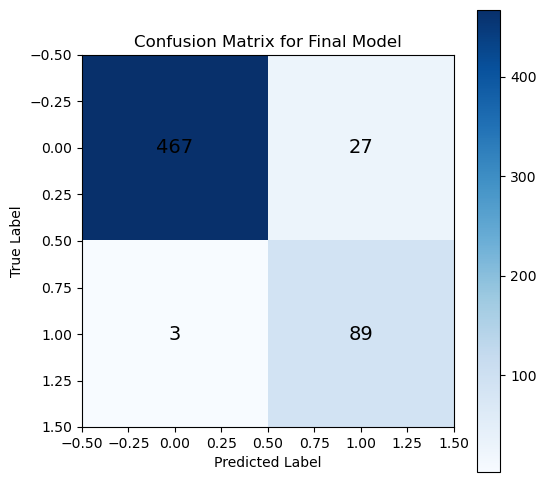


Best 3 models (ROC AUC) to prdict holdout:
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Holdout ROC AUC: 0.9862
Holdout Accuracy: 0.9471
Holdout MAE: 0.1823
Holdout Percision: 0.7607
Holdout Specificity: 0.9433
Holdout Sensitivity(Recall): 0.9674
Holdout F1: 0.8517 



array([[466,  28],
       [  3,  89]])

In [10]:
################# ORIGINAL 70 K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo Night
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_70_Original/Hypo_Night"
matrix_shape0 = 288
# Reshape matrices to the required shapes
X_features_daily_imputed = np.nan_to_num(X_features_daily_scaled, nan=0.0)
X_features_individual_imputed = np.nan_to_num(X_features_individual_scaled, nan=0.0)

# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_night = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_hypo_night, groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]    
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_hypo_night[train_idx],y_hypo_night[val_idx], y_hypo_night[test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]

    # Resample training data
    X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, \
    X_features_individual_train_resampled, mask_daily_train_resampled, \
    mask_individual_train_resampled, y_label_train_resampled = apply_smote_resampling_mask(
        X_matrices_coeffs_train,
        X_features_daily_train,
        X_features_individual_train,
        mask_daily_train,
        mask_individual_train,
        y_label_train, matrix_shape0=matrix_shape0
    )
    # Resample Validation data
    X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, \
    X_features_individual_val_resampled, mask_daily_val_resampled, \
    mask_individual_val_resampled, y_label_val_resampled = apply_smote_resampling_mask(
        X_matrices_coeffs_val,
        X_features_daily_val,
        X_features_individual_val,
        mask_daily_val,
        mask_individual_val,
        y_label_val, matrix_shape0=matrix_shape0
    )
    num_epochs = 35
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_accuracy', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    # Model training and evaluation
    history_hypo_night = model.fit([X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, X_features_individual_train_resampled, mask_daily_train_resampled, mask_individual_train_resampled], 
                                         y_label_train_resampled, 
                                         epochs=num_epochs, batch_size=32, verbose=1,
                                         validation_data=([X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, X_features_individual_val_resampled, mask_daily_val_resampled, mask_individual_val_resampled], y_label_val_resampled),
                                         callbacks=[early_stopping, learning_rate_scheduler])
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, X_features_individual_train_resampled, mask_daily_train_resampled, mask_individual_train_resampled], 
                                 y_label_train_resampled, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, X_features_individual_val_resampled, mask_daily_val_resampled, mask_individual_val_resampled], 
                                y_label_val_resampled, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train >= 0.5).astype(int)
    y_pred_test_binary = (y_pred_test >= 0.2).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_night["precision_scores"].append(precision)
    final_results_night["recall_scores"].append(recall)
    final_results_night["f1_scores"].append(f1)
    final_results_night["accuracy_scores"].append(accuracy)
    final_results_night["roc_auc_scores"].append(roc_auc_test)
    final_results_night["specificity_scores"].append(specificity)
    final_results_night["mae"].append(mae_test)
    final_results_night["mse"].append(mse_test)
    final_results_night["train_loss"].append(train_score[0])
    final_results_night["train_acc"].append(train_score[1])
    final_results_night["val_loss"].append(val_score[0])
    final_results_night["val_acc"].append(val_score[1])
    final_results_night["fold_train_acc"].append(history_hypo_night.history['accuracy'])
    final_results_night["fold_train_loss"].append(history_hypo_night.history['loss'])
    final_results_night["fold_val_acc"].append(history_hypo_night.history['val_accuracy'])
    final_results_night["fold_val_loss"].append(history_hypo_night.history['val_loss'])
    final_results_night["conf_matrix"].append(conf_matrix)
    final_results_night["class_report"].append(class_report)
    final_results_night["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_night["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_loss = np.zeros(max_epochs)
std_loss = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    losses = []
    accuracies = []
    for fold_loss, fold_acc in zip(final_results_night["fold_val_loss"], final_results_night["fold_val_acc"]):
        if epoch < len(fold_loss):
            losses.append(fold_loss[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if losses:
        avg_loss[epoch] = np.mean(losses)
        std_loss[epoch] = np.std(losses)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_loss, color='blue', label='Validation Loss')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_loss - std_loss,
                 avg_loss + std_loss,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_hypo_night[holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_night["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
    y_pred_holdout_avg = np.mean(y_pred_holdout_fold, axis=0)
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.4).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _ORIGINAL _Below70 Hypo, input w/ Masking, Daily & Individual input, Classifying Hypo Night
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_night, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_night["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_night["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.4).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix


Processing fold 1...
351, 69, 46, participants in Train, Validation, and Test sets
Class weights:  {0: 0.5849001603264831, 1: 3.4446351931330472}
Epoch 1/30




2024-10-02 00:54:12.107877: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



501/502 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.5833 - accuracy: 0.7015 - loss: 2.3997



2024-10-02 00:54:29.801605: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.5834 - accuracy: 0.7014 - loss: 2.3987

502/502 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - AUC: 0.5836 - accuracy: 0.7013 - loss: 2.3978 - val_AUC: 0.7698 - val_accuracy: 0.6365 - val_loss: 1.1716 - learning_rate: 1.0000e-04
Epoch 2/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - AUC: 0.7946 - accuracy: 0.7314 - loss: 1.1317 - val_AUC: 0.8300 - val_accuracy: 0.7609 - val_loss: 0.7949 - learning_rate: 1.0000e-04
Epoch 3/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.8369 - accuracy: 0.7341 - loss: 0.8368 - val_AUC: 0.8386 - val_accuracy: 0.7548 - val_loss: 0.7524 - learning_rate: 1.0000e-04
Epoch 4/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.8774 - accuracy: 0.7743 - loss: 0.6879 - val_AUC: 0.8612 - val_accuracy: 0.8043 - val_loss: 0.6356 - learning_rate: 1.0000e-04
Epoch 5/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - AUC: 0.9073 - accuracy: 0.8178 - loss: 0.5950 - val_AUC: 0.8467 - val_accuracy: 0.7561 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 6/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - AUC: 0.916



2024-10-02 00:57:22.275432: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2024-10-02 00:57:25.797766: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.4001213610172272, Train accuracy: 0.9081734418869019
Validation loss: 0.5328898429870605, Validation accuracy: 0.854619562625885




2024-10-02 00:57:49.375613: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



2024-10-02 00:57:52.690446: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step



2024-10-02 00:57:55.442256: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Test ROC AUC: 0.8875
Test Accuracy: 0.8109
Test MAE: 0.1786
Test Percision: 0.4073
Test Specificity: 0.8126
Test Sensitivity(Recall): 0.8000
Test F1: 0.5398 

Fold 1 - AUC: 0.8875, Accuracy: 0.8109, Recall: 0.8000, Precision: 0.4073, Specificity: 0.8126, F1: 0.5398

[[707 163]
 [ 28 112]]
Processing fold 2...
349, 70, 47, participants in Train, Validation, and Test sets
Class weights:  {0: 0.580752532561505, 1: 3.595878136200717}
Epoch 1/30




2024-10-02 00:58:51.354580: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



497/502 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.6132 - accuracy: 0.6516 - loss: 2.0835



2024-10-02 00:59:05.212504: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 0.6137 - accuracy: 0.6513 - loss: 2.0776



2024-10-02 00:59:10.542056: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2024-10-02 00:59:12.372111: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



502/502 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - AUC: 0.6139 - accuracy: 0.6512 - loss: 2.0764 - val_AUC: 0.7671 - val_accuracy: 0.6841 - val_loss: 0.8342 - learning_rate: 1.0000e-04
Epoch 2/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - AUC: 0.7862 - accuracy: 0.6909 - loss: 0.8799 - val_AUC: 0.7999 - val_accuracy: 0.6671 - val_loss: 0.7755 - learning_rate: 1.0000e-04
Epoch 3/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - AUC: 0.8376 - accuracy: 0.7334 - loss: 0.7362 - val_AUC: 0.8355 - val_accuracy: 0.7396 - val_loss: 0.7106 - learning_rate: 1.0000e-04
Epoch 4/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - AUC: 0.8807 - accuracy: 0.7834 - loss: 0.6454 - val_AUC: 0.8510 - val_accuracy: 0.7781 - val_loss: 0.6717 - learning_rate: 1.0000e-04
Epoch 5/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - AUC: 0.9064 - accuracy: 0.8094 - loss: 0.5892 - val_AUC: 0.8628 - val_accuracy: 0.8081 - val_loss: 0.5909 - learning_rate: 1.0000e-04
Epoch 6/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - AUC: 0.920







2024-10-02 01:04:46.503455: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.3517620861530304, Train accuracy: 0.9192624092102051
Validation loss: 0.5502704977989197, Validation accuracy: 0.8537858724594116


250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



2024-10-02 01:09:00.078282: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test ROC AUC: 0.8887
Test Accuracy: 0.8169
Test MAE: 0.1784
Test Percision: 0.4774
Test Specificity: 0.8239
Test Sensitivity(Recall): 0.7829
Test F1: 0.5931 

Fold 2 - AUC: 0.8887, Accuracy: 0.8169, Recall: 0.7829, Precision: 0.4774, Specificity: 0.8239, F1: 0.5931

[[702 150]
 [ 38 137]]
Processing fold 3...
349, 70, 47, participants in Train, Validation, and Test sets
Class weights:  {0: 0.579399451421972, 1: 3.6486363636363635}
Epoch 1/30


497/502 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.5699 - accuracy: 0.5857 - loss: 2.2167



2024-10-02 01:11:02.899307: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - AUC: 0.5708 - accuracy: 0.5860 - loss: 2.2110





2024-10-02 01:11:13.133035: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



502/502 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - AUC: 0.5709 - accuracy: 0.5861 - loss: 2.2099 - val_AUC: 0.6973 - val_accuracy: 0.5349 - val_loss: 1.0028 - learning_rate: 1.0000e-04
Epoch 2/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 0.7685 - accuracy: 0.6644 - loss: 0.9595 - val_AUC: 0.8218 - val_accuracy: 0.7429 - val_loss: 0.7240 - learning_rate: 1.0000e-04
Epoch 3/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 0.8405 - accuracy: 0.7454 - loss: 0.7475 - val_AUC: 0.8395 - val_accuracy: 0.7508 - val_loss: 0.7130 - learning_rate: 1.0000e-04
Epoch 4/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.8833 - accuracy: 0.7785 - loss: 0.6475 - val_AUC: 0.8684 - val_accuracy: 0.7455 - val_loss: 0.7264 - learning_rate: 1.0000e-04
Epoch 5/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.9192 - accuracy: 0.8305 - loss: 0.5561 - val_AUC: 0.8711 - val_accuracy: 0.7601 - val_loss: 0.7072 - learning_rate: 1.0000e-04
Epoch 6/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.927





2024-10-02 01:14:32.073980: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.2994927167892456, Train accuracy: 0.93708735704422
Validation loss: 0.5346757769584656, Validation accuracy: 0.869767427444458


248/251 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



2024-10-02 01:15:01.459498: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



2024-10-02 01:15:05.429283: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Test ROC AUC: 0.8871
Test Accuracy: 0.8717
Test MAE: 0.1350
Test Percision: 0.5606
Test Specificity: 0.9011
Test Sensitivity(Recall): 0.7070
Test F1: 0.6254 

Fold 3 - AUC: 0.8871, Accuracy: 0.8717, Recall: 0.7070, Precision: 0.5606, Specificity: 0.9011, F1: 0.6254

[[793  87]
 [ 46 111]]
Processing fold 4...
349, 70, 47, participants in Train, Validation, and Test sets
Class weights:  {0: 0.5804888631761643, 1: 3.6060197663971247}
Epoch 1/30


499/502 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - AUC: 0.5898 - accuracy: 0.7255 - loss: 2.5150

502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - AUC: 0.5902 - accuracy: 0.7252 - loss: 2.5123





2024-10-02 01:16:48.719991: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



502/502 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - AUC: 0.5903 - accuracy: 0.7252 - loss: 2.5114 - val_AUC: 0.7154 - val_accuracy: 0.6463 - val_loss: 1.3628 - learning_rate: 1.0000e-04
Epoch 2/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 0.7463 - accuracy: 0.6288 - loss: 1.2845 - val_AUC: 0.8053 - val_accuracy: 0.6508 - val_loss: 1.0420 - learning_rate: 1.0000e-04
Epoch 3/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 0.8345 - accuracy: 0.7238 - loss: 0.9621 - val_AUC: 0.8304 - val_accuracy: 0.6927 - val_loss: 0.9045 - learning_rate: 1.0000e-04
Epoch 4/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 0.9065 - accuracy: 0.7948 - loss: 0.7283 - val_AUC: 0.8615 - val_accuracy: 0.8270 - val_loss: 0.6630 - learning_rate: 1.0000e-04
Epoch 5/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.9188 - accuracy: 0.8310 - loss: 0.6302 - val_AUC: 0.8404 - val_accuracy: 0.7869 - val_loss: 0.6854 - learning_rate: 1.0000e-04
Epoch 6/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - AUC: 0.927


Train loss: 0.3499069809913635, Train accuracy: 0.9302354454994202
Validation loss: 0.5609224438667297, Validation accuracy: 0.8530534505844116


246/251 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


2024-10-02 01:23:30.359738: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



Test ROC AUC: 0.8994
Test Accuracy: 0.8429
Test MAE: 0.1566
Test Percision: 0.5149
Test Specificity: 0.8580
Test Sensitivity(Recall): 0.7658
Test F1: 0.6158 

Fold 4 - AUC: 0.8994, Accuracy: 0.8429, Recall: 0.7658, Precision: 0.5149, Specificity: 0.8580, F1: 0.6158

[[689 114]
 [ 37 121]]

Average Train Accuracy: 0.9237 (+- 0.0110)
Average Validation Accuracy: 0.8578 (+- 0.0069)
Average Test Accuracy: 0.8356 (+- 0.0241)
Average Test Recall: 0.7639 (+- 0.0350)
Average Test Precision: 0.4900 (+- 0.0561)
Average Test Specificity: 0.8489 (+- 0.0345)
Average Test AUC: 0.8907 (+- 0.0050)
Average Test F1: 0.5935 (+- 0.0332)


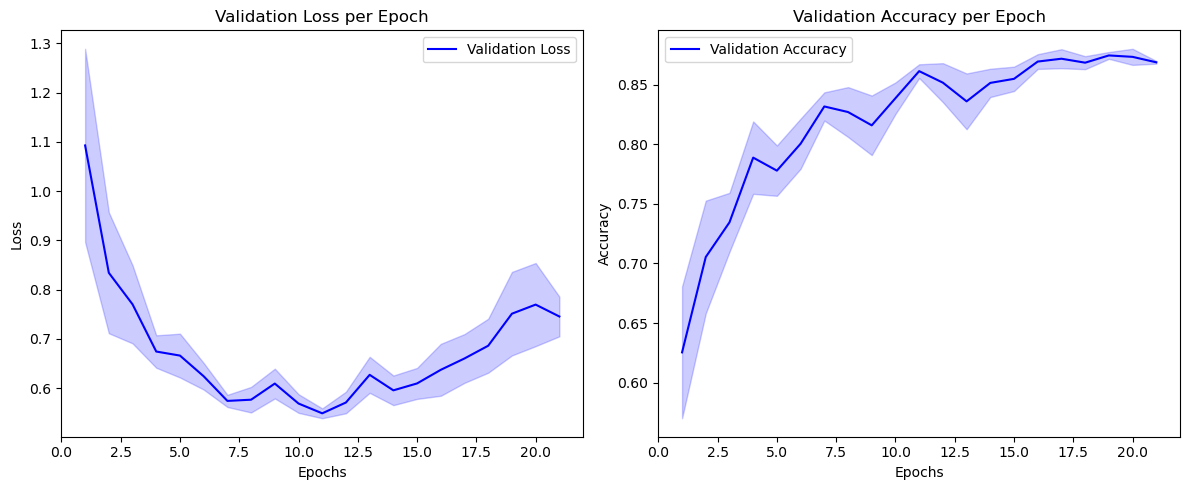

Aggregated Models on holdout set ... 

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step



2024-10-02 01:23:33.278904: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Holdout ROC AUC: 0.9800
Holdout Accuracy: 0.9317
Holdout MAE: 0.1566
Holdout Percision: 0.7000
Holdout Specificity: 0.9211
Holdout Sensitivity(Recall): 0.9891
Holdout F1: 0.8198 



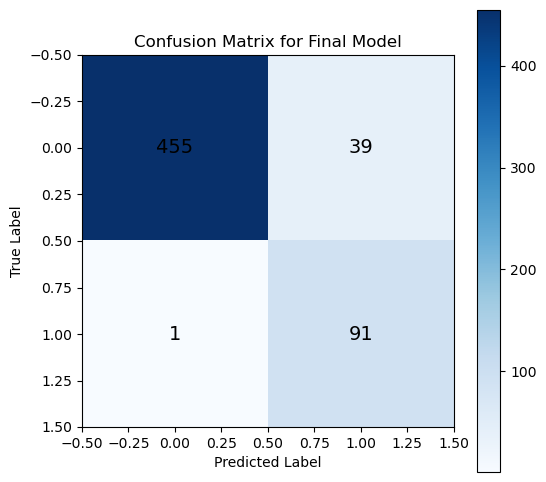


Best 3 models (ROC AUC) to prdict holdout:
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Holdout ROC AUC: 0.9768
Holdout Accuracy: 0.9078
Holdout MAE: 0.1566
Holdout Percision: 0.6357
Holdout Specificity: 0.8968
Holdout Sensitivity(Recall): 0.9674
Holdout F1: 0.7672 



array([[443,  51],
       [  3,  89]])

In [16]:
################# Class Weights Original 70 K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo Night
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_70_Original/Hypo_Night"
matrix_shape0 = 288
# Reshape matrices to the required shapes
X_features_daily_imputed = np.nan_to_num(X_features_daily_scaled, nan=0.0)
X_features_individual_imputed = np.nan_to_num(X_features_individual_scaled, nan=0.0)

# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_night = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
# # Enable mixed precision
# keras.mixed_precision.set_global_policy('mixed_float16')

for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_labels['hypo_night'], groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]    
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_labels['hypo_night'][train_idx],y_labels['hypo_night'][val_idx], y_labels['hypo_night'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]

    num_epochs = 30
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_AUC', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)
    y_label_train_flat = y_label_train.ravel()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_label_train_flat), y=y_label_train_flat)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights: ", class_weight_dict)
    history_hypo_night = model.fit([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                         y_label_train, 
                                         epochs=num_epochs, batch_size=16, verbose=1,
                                         validation_data=([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], y_label_val),
                                         callbacks=[early_stopping, learning_rate_scheduler],
                                         class_weight=class_weight_dict)
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                 y_label_train, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], 
                                y_label_val, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train >= 0.5).astype(int)
    y_pred_test_binary = (y_pred_test >= 0.3).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_night["precision_scores"].append(precision)
    final_results_night["recall_scores"].append(recall)
    final_results_night["f1_scores"].append(f1)
    final_results_night["accuracy_scores"].append(accuracy)
    final_results_night["roc_auc_scores"].append(roc_auc_test)
    final_results_night["specificity_scores"].append(specificity)
    final_results_night["mae"].append(mae_test)
    final_results_night["mse"].append(mse_test)
    final_results_night["train_loss"].append(train_score[0])
    final_results_night["train_acc"].append(train_score[1])
    final_results_night["val_loss"].append(val_score[0])
    final_results_night["val_acc"].append(val_score[1])
    final_results_night["fold_train_acc"].append(history_hypo_night.history['accuracy'])
    final_results_night["fold_train_loss"].append(history_hypo_night.history['loss'])
    final_results_night["fold_val_acc"].append(history_hypo_night.history['val_accuracy'])
    final_results_night["fold_val_loss"].append(history_hypo_night.history['val_loss'])
    final_results_night["conf_matrix"].append(conf_matrix)
    final_results_night["class_report"].append(class_report)
    final_results_night["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_night["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_loss = np.zeros(max_epochs)
std_loss = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    losses = []
    accuracies = []
    for fold_loss, fold_acc in zip(final_results_night["fold_val_loss"], final_results_night["fold_val_acc"]):
        if epoch < len(fold_loss):
            losses.append(fold_loss[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if losses:
        avg_loss[epoch] = np.mean(losses)
        std_loss[epoch] = np.std(losses)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_loss, color='blue', label='Validation Loss')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_loss - std_loss,
                 avg_loss + std_loss,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_night'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_night["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
    y_pred_holdout_avg = np.mean(y_pred_holdout_fold, axis=0)
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _Smooth _Below70 Hypo, input w/ Masking, Daily & Individual input, Classifying Hypo Night
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_night, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_night["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_night["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix



In [ ]:
# Run garbage collection
gc.collect()
################# Batch 64_Class Weights Original 70 K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo Night
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_70_Original/Hypo_Night"
matrix_shape0 = 288
# Reshape matrices to the required shapes
X_features_daily_imputed = np.nan_to_num(X_features_daily_scaled, nan=0.0)
X_features_individual_imputed = np.nan_to_num(X_features_individual_scaled, nan=0.0)

# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_night = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
# # Enable mixed precision
# keras.mixed_precision.set_global_policy('mixed_float16')

for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_labels['hypo_night'], groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]    
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_labels['hypo_night'][train_idx],y_labels['hypo_night'][val_idx], y_labels['hypo_night'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]

    num_epochs = 30
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_accuracy', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)
    y_label_train_flat = y_label_train.ravel()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_label_train_flat), y=y_label_train_flat)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights: ", class_weight_dict)
    history_hypo_night = model.fit([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                         y_label_train, 
                                         epochs=num_epochs, batch_size=64, verbose=1,
                                         validation_data=([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], y_label_val),
                                         callbacks=[early_stopping, learning_rate_scheduler, checkpoint],
                                         class_weight=class_weight_dict)
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                 y_label_train, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], 
                                y_label_val, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train >= 0.5).astype(int)
    y_pred_test_binary = (y_pred_test >= 0.3).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_night["precision_scores"].append(precision)
    final_results_night["recall_scores"].append(recall)
    final_results_night["f1_scores"].append(f1)
    final_results_night["accuracy_scores"].append(accuracy)
    final_results_night["roc_auc_scores"].append(roc_auc_test)
    final_results_night["specificity_scores"].append(specificity)
    final_results_night["mae"].append(mae_test)
    final_results_night["mse"].append(mse_test)
    final_results_night["train_loss"].append(train_score[0])
    final_results_night["train_acc"].append(train_score[1])
    final_results_night["val_loss"].append(val_score[0])
    final_results_night["val_acc"].append(val_score[1])
    final_results_night["fold_train_acc"].append(history_hypo_night.history['accuracy'])
    final_results_night["fold_train_loss"].append(history_hypo_night.history['loss'])
    final_results_night["fold_val_acc"].append(history_hypo_night.history['val_accuracy'])
    final_results_night["fold_val_loss"].append(history_hypo_night.history['val_loss'])
    final_results_night["conf_matrix"].append(conf_matrix)
    final_results_night["class_report"].append(class_report)
    final_results_night["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_night["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_loss = np.zeros(max_epochs)
std_loss = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    losses = []
    accuracies = []
    for fold_loss, fold_acc in zip(final_results_night["fold_val_loss"], final_results_night["fold_val_acc"]):
        if epoch < len(fold_loss):
            losses.append(fold_loss[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if losses:
        avg_loss[epoch] = np.mean(losses)
        std_loss[epoch] = np.std(losses)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_loss, color='blue', label='Validation Loss')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_loss - std_loss,
                 avg_loss + std_loss,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_night'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_night["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
    y_pred_holdout_avg = np.mean(y_pred_holdout_fold, axis=0)
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _Smooth _Below70 Hypo, input w/ Masking, Daily & Individual input, Classifying Hypo Night
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_night["train_acc"]):.4f} (+- {np.std(final_results_night["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_night["val_acc"]):.4f} (+- {np.std(final_results_night["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_night["accuracy_scores"]):.4f} (+- {np.std(final_results_night["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_night["recall_scores"]):.4f} (+- {np.std(final_results_night["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_night["precision_scores"]):.4f} (+- {np.std(final_results_night["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_night["specificity_scores"]):.4f} (+- {np.std(final_results_night["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_night["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_night["f1_scores"]):.4f} (+- {np.std(final_results_night["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_night, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_night["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_night["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix


In [14]:
# Run garbage collection
gc.collect()
################# ORIGINAL 70 K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo early_night
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_70_Original/Hypo_Early_Night"
matrix_shape0 = 288
# Reshape matrices to the required shapes
X_features_daily_imputed = np.nan_to_num(X_features_daily_scaled, nan=0.0)
X_features_individual_imputed = np.nan_to_num(X_features_individual_scaled, nan=0.0)

# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_early_night = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
# # Enable mixed precision
# keras.mixed_precision.set_global_policy('mixed_float16')

for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_labels['hypo_early_night'], groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]
    # train_participants = shuffle(train_participants, random_state=42)  # Shuffle train participants
    
    # Randomly shuffle and Split remaining data into validation and test based on participants
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    # val_test_participants = shuffle(val_test_participants, random_state=42)  # Shuffle val_test participants
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_labels['hypo_early_night'][train_idx],y_labels['hypo_early_night'][val_idx], y_labels['hypo_early_night'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]

    # Resample training data
    X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, \
    X_features_individual_train_resampled, mask_daily_train_resampled, \
    mask_individual_train_resampled, y_label_train_resampled = apply_smote_resampling_mask(
        X_matrices_coeffs_train,
        X_features_daily_train,
        X_features_individual_train,
        mask_daily_train,
        mask_individual_train,
        y_label_train, matrix_shape0=matrix_shape0
    )
    # Resample Validation data
    X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, \
    X_features_individual_val_resampled, mask_daily_val_resampled, \
    mask_individual_val_resampled, y_label_val_resampled = apply_smote_resampling_mask(
        X_matrices_coeffs_val,
        X_features_daily_val,
        X_features_individual_val,
        mask_daily_val,
        mask_individual_val,
        y_label_val, matrix_shape0=matrix_shape0
    )
    num_epochs = 25
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_accuracy', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)
    # Model training and evaluation
    history_hypo_early_night = model.fit([X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, X_features_individual_train_resampled, mask_daily_train_resampled, mask_individual_train_resampled], 
                                         y_label_train_resampled, 
                                         epochs=num_epochs, batch_size=16, verbose=1,
                                         validation_data=([X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, X_features_individual_val_resampled, mask_daily_val_resampled, mask_individual_val_resampled], y_label_val_resampled),
                                         callbacks=[early_stopping, learning_rate_scheduler])
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, X_features_individual_train_resampled, mask_daily_train_resampled, mask_individual_train_resampled], 
                                 y_label_train_resampled, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, X_features_individual_val_resampled, mask_daily_val_resampled, mask_individual_val_resampled], 
                                y_label_val_resampled, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train >= 0.5).astype(int)
    y_pred_test_binary = (y_pred_test >= 0.2).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_early_night["precision_scores"].append(precision)
    final_results_early_night["recall_scores"].append(recall)
    final_results_early_night["f1_scores"].append(f1)
    final_results_early_night["accuracy_scores"].append(accuracy)
    final_results_early_night["roc_auc_scores"].append(roc_auc_test)
    final_results_early_night["specificity_scores"].append(specificity)
    final_results_early_night["mae"].append(mae_test)
    final_results_early_night["mse"].append(mse_test)
    final_results_early_night["train_loss"].append(train_score[0])
    final_results_early_night["train_acc"].append(train_score[1])
    final_results_early_night["val_loss"].append(val_score[0])
    final_results_early_night["val_acc"].append(val_score[1])
    final_results_early_night["fold_train_acc"].append(history_hypo_early_night.history['accuracy'])
    final_results_early_night["fold_train_loss"].append(history_hypo_early_night.history['loss'])
    final_results_early_night["fold_val_acc"].append(history_hypo_early_night.history['val_accuracy'])
    final_results_early_night["fold_val_loss"].append(history_hypo_early_night.history['val_loss'])
    final_results_early_night["conf_matrix"].append(conf_matrix)
    final_results_early_night["class_report"].append(class_report)
    final_results_early_night["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_early_night["train_acc"]):.4f} (+- {np.std(final_results_early_night["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_early_night["val_acc"]):.4f} (+- {np.std(final_results_early_night["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_early_night["accuracy_scores"]):.4f} (+- {np.std(final_results_early_night["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_early_night["recall_scores"]):.4f} (+- {np.std(final_results_early_night["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_early_night["precision_scores"]):.4f} (+- {np.std(final_results_early_night["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_early_night["specificity_scores"]):.4f} (+- {np.std(final_results_early_night["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_early_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_early_night["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_early_night["f1_scores"]):.4f} (+- {np.std(final_results_early_night["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_early_night["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_loss = np.zeros(max_epochs)
std_loss = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    losses = []
    accuracies = []
    for fold_loss, fold_acc in zip(final_results_early_night["fold_val_loss"], final_results_early_night["fold_val_acc"]):
        if epoch < len(fold_loss):
            losses.append(fold_loss[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if losses:
        avg_loss[epoch] = np.mean(losses)
        std_loss[epoch] = np.std(losses)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_loss, color='blue', label='Validation Loss')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_loss - std_loss,
                 avg_loss + std_loss,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_early_night'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_early_night["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.4).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'holdout_conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _ORIGINAL _Below70 Hypo Early Night, input w/ Masking, Daily & Individual input, Classifying Hypo Early Night
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_early_night["train_acc"]):.4f} (+- {np.std(final_results_early_night["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_early_night["val_acc"]):.4f} (+- {np.std(final_results_early_night["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_early_night["accuracy_scores"]):.4f} (+- {np.std(final_results_early_night["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_early_night["recall_scores"]):.4f} (+- {np.std(final_results_early_night["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_early_night["precision_scores"]):.4f} (+- {np.std(final_results_early_night["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_early_night["specificity_scores"]):.4f} (+- {np.std(final_results_early_night["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_early_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_early_night["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_early_night["f1_scores"]):.4f} (+- {np.std(final_results_early_night["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_early_night, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_early_night["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_early_night["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.4).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix


Processing fold 1...
351, 69, 46, participants in Train, Validation, and Test sets
Epoch 1/25


2024-10-02 00:08:50.854788: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



907/909 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8141 - accuracy: 0.7369 - loss: 1.8511

2024-10-02 00:09:09.036735: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-02 00:09:09.061279: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-02 00:09:09.071561: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-02 00:09:09.079277: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas be

909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - AUC: 0.8143 - accuracy: 0.7372 - loss: 1.8496

2024-10-02 00:10:03.757897: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-02 00:10:03.767927: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-02 00:10:03.770006: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-10-02 00:10:03.777220: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas be

909/909 ━━━━━━━━━━━━━━━━━━━━ 120s 113ms/step - AUC: 0.8145 - accuracy: 0.7373 - loss: 1.8489 - val_AUC: 0.9650 - val_accuracy: 0.9038 - val_loss: 0.5501 - learning_rate: 1.0000e-04
Epoch 2/25
909/909 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - AUC: 0.9799 - accuracy: 0.9349 - loss: 0.4503 - val_AUC: 0.9708 - val_accuracy: 0.9181 - val_loss: 0.4447 - learning_rate: 1.0000e-04
Epoch 3/25
909/909 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - AUC: 0.9889 - accuracy: 0.9535 - loss: 0.3451 - val_AUC: 0.9832 - val_accuracy: 0.9291 - val_loss: 0.3879 - learning_rate: 1.0000e-04
Epoch 4/25
909/909 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - AUC: 0.9904 - accuracy: 0.9483 - loss: 0.3391 - val_AUC: 0.9667 - val_accuracy: 0.8998 - val_loss: 0.4167 - learning_rate: 1.0000e-04
Epoch 5/25
909/909 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - AUC: 0.9519 - accuracy: 0.8385 - loss: 0.5026 - val_AUC: 0.8664 - val_accuracy: 0.5793 - val_loss: 0.7848 - learning_rate: 1.0000e-04
Epoch 6/25
909/909 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - AUC

KeyboardInterrupt: 

In [ ]:
# Run garbage collection
gc.collect()
################# ORIGINAL 70 K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo Late Night
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_70_Original/Hypo_Late_Night"
matrix_shape0 = 288
# Reshape matrices to the required shapes
X_features_daily_imputed = np.nan_to_num(X_features_daily_scaled, nan=0.0)
X_features_individual_imputed = np.nan_to_num(X_features_individual_scaled, nan=0.0)

# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_late_night = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_labels['hypo_late_night'], groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]
    # train_participants = shuffle(train_participants, random_state=42)  # Shuffle train participants
    
    # Randomly shuffle and Split remaining data into validation and test based on participants
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    # val_test_participants = shuffle(val_test_participants, random_state=42)  # Shuffle val_test participants
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_labels['hypo_late_night'][train_idx],y_labels['hypo_late_night'][val_idx], y_labels['hypo_late_night'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]

    # Resample training data
    X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, \
    X_features_individual_train_resampled, mask_daily_train_resampled, \
    mask_individual_train_resampled, y_label_train_resampled = apply_smote_resampling_mask(
        X_matrices_coeffs_train,
        X_features_daily_train,
        X_features_individual_train,
        mask_daily_train,
        mask_individual_train,
        y_label_train, matrix_shape0=matrix_shape0
    )
    # Resample Validation data
    X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, \
    X_features_individual_val_resampled, mask_daily_val_resampled, \
    mask_individual_val_resampled, y_label_val_resampled = apply_smote_resampling_mask(
        X_matrices_coeffs_val,
        X_features_daily_val,
        X_features_individual_val,
        mask_daily_val,
        mask_individual_val,
        y_label_val, matrix_shape0=matrix_shape0
    )
    num_epochs = 25
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    # checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_accuracy', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
    # Model training and evaluation
    history_hypo_late_night = model.fit([X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, X_features_individual_train_resampled, mask_daily_train_resampled, mask_individual_train_resampled], 
                                         y_label_train_resampled, 
                                         epochs=num_epochs, batch_size=16, verbose=1,
                                         validation_data=([X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, X_features_individual_val_resampled, mask_daily_val_resampled, mask_individual_val_resampled], y_label_val_resampled),
                                         callbacks=[early_stopping, learning_rate_scheduler])
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, X_features_individual_train_resampled, mask_daily_train_resampled, mask_individual_train_resampled], 
                                 y_label_train_resampled, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, X_features_individual_val_resampled, mask_daily_val_resampled, mask_individual_val_resampled], 
                                y_label_val_resampled, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train >= 0.5).astype(int)
    y_pred_test_binary = (y_pred_test >= 0.2).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_late_night["precision_scores"].append(precision)
    final_results_late_night["recall_scores"].append(recall)
    final_results_late_night["f1_scores"].append(f1)
    final_results_late_night["accuracy_scores"].append(accuracy)
    final_results_late_night["roc_auc_scores"].append(roc_auc_test)
    final_results_late_night["specificity_scores"].append(specificity)
    final_results_late_night["mae"].append(mae_test)
    final_results_late_night["mse"].append(mse_test)
    final_results_late_night["train_loss"].append(train_score[0])
    final_results_late_night["train_acc"].append(train_score[1])
    final_results_late_night["val_loss"].append(val_score[0])
    final_results_late_night["val_acc"].append(val_score[1])
    final_results_late_night["fold_train_acc"].append(history_hypo_late_night.history['accuracy'])
    final_results_late_night["fold_train_loss"].append(history_hypo_late_night.history['loss'])
    final_results_late_night["fold_val_acc"].append(history_hypo_late_night.history['val_accuracy'])
    final_results_late_night["fold_val_loss"].append(history_hypo_late_night.history['val_loss'])
    final_results_late_night["conf_matrix"].append(conf_matrix)
    final_results_late_night["class_report"].append(class_report)
    final_results_late_night["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_late_night["train_acc"]):.4f} (+- {np.std(final_results_late_night["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_late_night["val_acc"]):.4f} (+- {np.std(final_results_late_night["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_late_night["accuracy_scores"]):.4f} (+- {np.std(final_results_late_night["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_late_night["recall_scores"]):.4f} (+- {np.std(final_results_late_night["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_late_night["precision_scores"]):.4f} (+- {np.std(final_results_late_night["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_late_night["specificity_scores"]):.4f} (+- {np.std(final_results_late_night["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_late_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_late_night["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_late_night["f1_scores"]):.4f} (+- {np.std(final_results_late_night["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_late_night["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_loss = np.zeros(max_epochs)
std_loss = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    losses = []
    accuracies = []
    for fold_loss, fold_acc in zip(final_results_late_night["fold_val_loss"], final_results_late_night["fold_val_acc"]):
        if epoch < len(fold_loss):
            losses.append(fold_loss[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if losses:
        avg_loss[epoch] = np.mean(losses)
        std_loss[epoch] = np.std(losses)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_loss, color='blue', label='Validation Loss')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_loss - std_loss,
                 avg_loss + std_loss,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_late_night'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_late_night["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.4).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'holdout_conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _ORIGINAL _Below70 Hypo Late Night, input w/ Masking, Daily & Individual input, Classifying Hypo Late Night
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_late_night["train_acc"]):.4f} (+- {np.std(final_results_late_night["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_late_night["val_acc"]):.4f} (+- {np.std(final_results_late_night["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_late_night["accuracy_scores"]):.4f} (+- {np.std(final_results_late_night["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_late_night["recall_scores"]):.4f} (+- {np.std(final_results_late_night["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_late_night["precision_scores"]):.4f} (+- {np.std(final_results_late_night["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_late_night["specificity_scores"]):.4f} (+- {np.std(final_results_late_night["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_late_night["roc_auc_scores"]):.4f} (+- {np.std(final_results_late_night["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_late_night["f1_scores"]):.4f} (+- {np.std(final_results_late_night["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_late_night, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_late_night["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_late_night["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg >= 0.4).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix


Processing fold 1...
351, 69, 46, participants in Train, Validation, and Test sets
Epoch 1/25


923/925 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.7527 - accuracy: 0.6830 - loss: 1.9786

925/925 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.7529 - accuracy: 0.6832 - loss: 1.9773

925/925 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - AUC: 0.7530 - accuracy: 0.6833 - loss: 1.9767 - val_AUC: 0.9610 - val_accuracy: 0.9087 - val_loss: 0.6803 - learning_rate: 1.0000e-04
Epoch 2/25
925/925 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - AUC: 0.9642 - accuracy: 0.9098 - loss: 0.6105 - val_AUC: 0.9780 - val_accuracy: 0.9313 - val_loss: 0.4411 - learning_rate: 1.0000e-04
Epoch 3/25
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - AUC: 0.9810 - accuracy: 0.9388 - loss: 0.3912 - val_AUC: 0.9789 - val_accuracy: 0.9342 - val_loss: 0.3783 - learning_rate: 1.0000e-04
Epoch 4/25
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - AUC: 0.9897 - accuracy: 0.9548 - loss: 0.2982 - val_AUC: 0.9760 - val_accuracy: 0.9393 - val_loss: 0.3510 - learning_rate: 1.0000e-04
Epoch 5/25
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - AUC: 0.9921 - accuracy: 0.9634 - loss: 0.2555 - val_AUC: 0.9730 - val_accuracy: 0.9389 - val_loss: 0.3650 - learning_rate: 1.0000e-04
Epoch 6/25
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - AUC: 



2024-10-02 02:15:40.528245: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2024-10-02 02:15:46.650216: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



2024-10-02 02:15:54.254867: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.




Train loss: 0.23586449027061462, Train accuracy: 0.9715348482131958
Validation loss: 0.3509770333766937, Validation accuracy: 0.9392523169517517


247/251 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Test ROC AUC: 0.8148
Test Accuracy: 0.9010
Test MAE: 0.1090
Test Percision: 0.4078
Test Specificity: 0.9343
Test Sensitivity(Recall): 0.5185
Test F1: 0.4565 

Fold 1 - AUC: 0.8148, Accuracy: 0.9010, Recall: 0.5185, Precision: 0.4078, Specificity: 0.9343, F1: 0.4565

[[868  61]
 [ 39  42]]
Processing fold 2...
349, 70, 47, participants in Train, Validation, and Test sets


In [ ]:
################# ORIGINAL 70 K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo night_morning
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_70_Original/Hypo_Night_Morning"
matrix_shape0 = 288
# Reshape matrices to the required shapes
X_features_daily_imputed = np.nan_to_num(X_features_daily_scaled, nan=0.0)
X_features_individual_imputed = np.nan_to_num(X_features_individual_scaled, nan=0.0)

# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]

final_results_night_morning = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_labels['hypo_night_morning'], groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]
    # train_participants = shuffle(train_participants, random_state=42)  # Shuffle train participants
    
    # Randomly shuffle and Split remaining data into validation and test based on participants
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    # val_test_participants = shuffle(val_test_participants, random_state=42)  # Shuffle val_test participants
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_labels['hypo_night_morning'][train_idx],y_labels['hypo_night_morning'][val_idx], y_labels['hypo_night_morning'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]

    # Resample training data
    X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, \
    X_features_individual_train_resampled, mask_daily_train_resampled, \
    mask_individual_train_resampled, y_label_train_resampled = apply_smote_resampling_mask(
        X_matrices_coeffs_train,
        X_features_daily_train,
        X_features_individual_train,
        mask_daily_train,
        mask_individual_train,
        y_label_train, matrix_shape0=matrix_shape0
    )
    # Resample Validation data
    X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, \
    X_features_individual_val_resampled, mask_daily_val_resampled, \
    mask_individual_val_resampled, y_label_val_resampled = apply_smote_resampling_mask(
        X_matrices_coeffs_val,
        X_features_daily_val,
        X_features_individual_val,
        mask_daily_val,
        mask_individual_val,
        y_label_val, matrix_shape0=matrix_shape0
    )
    num_epochs = 25
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
    # checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_accuracy', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)
    # Model training and evaluation
    history_hypo_night_morning = model.fit([X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, X_features_individual_train_resampled, mask_daily_train_resampled, mask_individual_train_resampled], 
                                         y_label_train_resampled, 
                                         epochs=num_epochs, batch_size=16, verbose=1,
                                         validation_data=([X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, X_features_individual_val_resampled, mask_daily_val_resampled, mask_individual_val_resampled], y_label_val_resampled),
                                         callbacks=[early_stopping, learning_rate_scheduler])
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, X_features_individual_train_resampled, mask_daily_train_resampled, mask_individual_train_resampled], 
                                 y_label_train_resampled, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, X_features_individual_val_resampled, mask_daily_val_resampled, mask_individual_val_resampled], 
                                y_label_val_resampled, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train > 0.5).astype(int)
    y_pred_test_binary = (y_pred_test > 0.5).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_night_morning["precision_scores"].append(precision)
    final_results_night_morning["recall_scores"].append(recall)
    final_results_night_morning["f1_scores"].append(f1)
    final_results_night_morning["accuracy_scores"].append(accuracy)
    final_results_night_morning["roc_auc_scores"].append(roc_auc_test)
    final_results_night_morning["specificity_scores"].append(specificity)
    final_results_night_morning["mae"].append(mae_test)
    final_results_night_morning["mse"].append(mse_test)
    final_results_night_morning["train_loss"].append(train_score[0])
    final_results_night_morning["train_acc"].append(train_score[1])
    final_results_night_morning["val_loss"].append(val_score[0])
    final_results_night_morning["val_acc"].append(val_score[1])
    final_results_night_morning["fold_train_acc"].append(history_hypo_night_morning.history['accuracy'])
    final_results_night_morning["fold_train_loss"].append(history_hypo_night_morning.history['loss'])
    final_results_night_morning["fold_val_acc"].append(history_hypo_night_morning.history['val_accuracy'])
    final_results_night_morning["fold_val_loss"].append(history_hypo_night_morning.history['val_loss'])
    final_results_night_morning["conf_matrix"].append(conf_matrix)
    final_results_night_morning["class_report"].append(class_report)
    final_results_night_morning["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_night_morning["train_acc"]):.4f} (+- {np.std(final_results_night_morning["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_night_morning["val_acc"]):.4f} (+- {np.std(final_results_night_morning["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_night_morning["accuracy_scores"]):.4f} (+- {np.std(final_results_night_morning["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_night_morning["recall_scores"]):.4f} (+- {np.std(final_results_night_morning["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_night_morning["precision_scores"]):.4f} (+- {np.std(final_results_night_morning["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_night_morning["specificity_scores"]):.4f} (+- {np.std(final_results_night_morning["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_night_morning["roc_auc_scores"]):.4f} (+- {np.std(final_results_night_morning["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_night_morning["f1_scores"]):.4f} (+- {np.std(final_results_night_morning["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_night_morning["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_loss = np.zeros(max_epochs)
std_loss = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    losses = []
    accuracies = []
    for fold_loss, fold_acc in zip(final_results_night_morning["fold_val_loss"], final_results_night_morning["fold_val_acc"]):
        if epoch < len(fold_loss):
            losses.append(fold_loss[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if losses:
        avg_loss[epoch] = np.mean(losses)
        std_loss[epoch] = np.std(losses)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_loss, color='blue', label='Validation Loss')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_loss - std_loss,
                 avg_loss + std_loss,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_night_morning'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_night_morning["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg > 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'holdout_conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel _ORIGINAL _Below70 Hypo Night+Morning, input w/ Masking, Daily & Individual input, Classifying Hypo Night & Morning
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_night_morning["train_acc"]):.4f} (+- {np.std(final_results_night_morning["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_night_morning["val_acc"]):.4f} (+- {np.std(final_results_night_morning["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_night_morning["accuracy_scores"]):.4f} (+- {np.std(final_results_night_morning["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_night_morning["recall_scores"]):.4f} (+- {np.std(final_results_night_morning["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_night_morning["precision_scores"]):.4f} (+- {np.std(final_results_night_morning["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_night_morning["specificity_scores"]):.4f} (+- {np.std(final_results_night_morning["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_night_morning["roc_auc_scores"]):.4f} (+- {np.std(final_results_night_morning["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_night_morning["f1_scores"]):.4f} (+- {np.std(final_results_night_morning["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_night_morning, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_night_morning["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_night_morning["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg > 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix


In [ ]:
################# AUC Focued ORIGINAL 70 K_Fold 3-channel input w/ Masking, Daily & Individual input, Classifying Hypo day
########################################################################################################################################
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
folder_name = "/home/ma98/Compressed_DEXI_Data/Hypo_70_Original/Hypo_Day"

matrix_shape0 = 288
# Reshape matrices to the required shapes
X_features_daily_imputed = np.nan_to_num(X_features_daily_scaled, nan=0.0)
X_features_individual_imputed = np.nan_to_num(X_features_individual_scaled, nan=0.0)

# Create masks for missing values
mask_daily = np.isfinite(X_features_daily_scaled).astype(np.float32)
mask_individual = np.isfinite(X_features_individual_scaled).astype(np.float32)

# Initialize GroupKFold
num_splits = 4
group_kfold = GroupKFold(n_splits=num_splits)
unique_participants = np.unique(participant_ids)
# # Shuffle to ensure no artifacts in test train/validation split
# unique_participants = shuffle(unique_participants, random_state=42)

# Completely hold out a test set before cross-validation
holdout_participants = unique_participants[int(0.95 * len(unique_participants)):]
holdout_idx = np.where(np.isin(participant_ids, holdout_participants))[0]

# Remove the holdout participants from the pool used for cross-validation model
model_participants = unique_participants[:int(0.95 * len(unique_participants))]
final_results_day = {
    "fold_model": [],
    "specificity_scores": [],
    "accuracy_scores": [],
    "precision_scores": [],
    "recall_scores": [],
    "f1_scores": [],
    "roc_auc_scores": [],
    "mae": [],
    "mse": [],
    "fold_train_loss": [],
    "fold_train_acc": [],
    "fold_val_loss": [],
    "fold_val_acc": [],
    "conf_matrix": [],
    "class_report": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
for fold, (train_idx, val_test_idx) in enumerate(group_kfold.split(X_matrices_power_scaled, y_labels['hypo_day'], groups=participant_ids)):
    # 75% of the data as train set
    train_participants = model_participants[np.isin(model_participants, participant_ids[train_idx])]
    # train_participants = shuffle(train_participants, random_state=42)  # Shuffle train participants
    
    # Randomly shuffle and Split remaining data into validation and test based on participants
    val_test_participants = model_participants[np.isin(model_participants, participant_ids[val_test_idx])]
    # val_test_participants = shuffle(val_test_participants, random_state=42)  # Shuffle val_test participants
    
    val_size = int(len(val_test_participants) * 3 / 5)
    val_participants = val_test_participants[:val_size]
    test_participants = val_test_participants[val_size:]
    
    # Get corresponding indices
    val_idx = np.where(np.isin(participant_ids, val_participants))[0]
    test_idx = np.where(np.isin(participant_ids, test_participants))[0]
    print(f"Processing fold {fold + 1}...")
    print(f"{len(train_participants)}, {len(val_participants)}, {len(test_participants)}, participants in Train, Validation, and Test sets" )

    # Train-test split based on indices
    X_matrices_coeffs_train,X_matrices_coeffs_val, X_matrices_coeffs_test = X_matrices_power_scaled[train_idx],X_matrices_power_scaled[val_idx], X_matrices_power_scaled[test_idx]
    X_features_daily_train,X_features_daily_val, X_features_daily_test = X_features_daily_imputed[train_idx],X_features_daily_imputed[val_idx], X_features_daily_imputed[test_idx]
    X_features_individual_train,X_features_individual_val, X_features_individual_test = X_features_individual_imputed[train_idx],X_features_individual_imputed[val_idx], X_features_individual_imputed[test_idx]
    y_label_train,y_label_val, y_label_test = y_labels['hypo_day'][train_idx],y_labels['hypo_day'][val_idx], y_labels['hypo_day'][test_idx]
    mask_daily_train,mask_daily_val, mask_daily_test = mask_daily[train_idx], mask_daily[val_idx], mask_daily[test_idx]
    mask_individual_train,mask_individual_val, mask_individual_test = mask_individual[train_idx],mask_individual[val_idx], mask_individual[test_idx]
    num_epochs = 25
    # Create a new model instance
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
    # checkpoint = ModelCheckpoint(filepath=os.path.join(folder_name, 'best_model_fold_{}.keras'.format(fold)), monitor='val_AUC', save_best_only=True, mode='max')
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)
    y_label_train_flat = y_label_train.ravel()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_label_train_flat), y=y_label_train_flat)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights: ", class_weight_dict)
    history_hypo_day = model.fit([X_matrices_coeffs_train, X_features_daily_train, X_features_individual_train, mask_daily_train, mask_individual_train], 
                                         y_label_train, 
                                         epochs=num_epochs, batch_size=16, verbose=1,
                                         validation_data=([X_matrices_coeffs_val, X_features_daily_val, X_features_individual_val, mask_daily_val, mask_individual_val], y_label_val),
                                         callbacks=[early_stopping, learning_rate_scheduler],
                                         class_weight=class_weight_dict)
    # Evaluate training and testing performance
    train_score = model.evaluate([X_matrices_coeffs_train_resampled, X_features_daily_train_resampled, X_features_individual_train_resampled, mask_daily_train_resampled, mask_individual_train_resampled], 
                                 y_label_train_resampled, verbose=0)
    val_score = model.evaluate([X_matrices_coeffs_val_resampled, X_features_daily_val_resampled, X_features_individual_val_resampled, mask_daily_val_resampled, mask_individual_val_resampled], 
                                y_label_val_resampled, verbose=0)
    print('\nTrain loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    print('Validation loss: {}, Validation accuracy: {}'.format(val_score[0], val_score[1]))
    # print('Test loss: {}, Test accuracy: {}\n'.format(test_score[0], test_score[1]))
    y_pred_train = model.predict([X_matrices_coeffs_train, X_features_daily_train,X_features_individual_train, mask_daily_train, mask_individual_train])
    y_pred_test = model.predict([X_matrices_coeffs_test, X_features_daily_test,X_features_individual_test, mask_daily_test, mask_individual_test])

    mae_train = mean_absolute_error(y_label_train, y_pred_train)
    mse_train = mean_squared_error(y_label_train, y_pred_train)

    roc_auc_test = roc_auc_score(y_label_test, y_pred_test)
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

    y_pred_train_binary = (y_pred_train > 0.5).astype(int)
    y_pred_test_binary = (y_pred_test > 0.5).astype(int)
    mae_test = mean_absolute_error(y_label_test, y_pred_test)
    mse_test = mean_squared_error(y_label_test, y_pred_test)
    accuracy = accuracy_score(y_label_test, y_pred_test_binary)
    recall = recall_score(y_label_test, y_pred_test_binary)
    f1 = f1_score(y_label_test, y_pred_test_binary)
    precision = precision_score(y_label_test, y_pred_test_binary)
    specificity = recall_score(y_label_test, y_pred_test_binary, pos_label=0)
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test MAE: {mae_test:.4f}')
    print(f'Test Percision: {precision:.4f}')
    print(f'Test Specificity: {specificity:.4f}')
    print(f'Test Sensitivity(Recall): {recall:.4f}')
    print(f'Test F1: {f1:.4f} \n')
    print(f'Fold {fold + 1} - AUC: {roc_auc_test:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, F1: {f1:.4f}\n')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_label_test, y_pred_test_binary)
    # Classification Report
    class_report = classification_report(y_label_test, y_pred_test_binary)
    print(conf_matrix)
    final_results_day["precision_scores"].append(precision)
    final_results_day["recall_scores"].append(recall)
    final_results_day["f1_scores"].append(f1)
    final_results_day["accuracy_scores"].append(accuracy)
    final_results_day["roc_auc_scores"].append(roc_auc_test)
    final_results_day["specificity_scores"].append(specificity)
    final_results_day["mae"].append(mae_test)
    final_results_day["mse"].append(mse_test)
    final_results_day["train_loss"].append(train_score[0])
    final_results_day["train_acc"].append(train_score[1])
    final_results_day["val_loss"].append(val_score[0])
    final_results_day["val_acc"].append(val_score[1])
    final_results_day["fold_train_acc"].append(history_hypo_day.history['accuracy'])
    final_results_day["fold_train_loss"].append(history_hypo_day.history['loss'])
    final_results_day["fold_val_acc"].append(history_hypo_day.history['val_accuracy'])
    final_results_day["fold_val_loss"].append(history_hypo_day.history['val_loss'])
    final_results_day["conf_matrix"].append(conf_matrix)
    final_results_day["class_report"].append(class_report)
    final_results_day["fold_model"].append(model)
          
# Calculate and print average and std across folds
print(f'\nAverage Train Accuracy: {np.mean(final_results_day["train_acc"]):.4f} (+- {np.std(final_results_day["train_acc"]):.4f})')
print(f'Average Validation Accuracy: {np.mean(final_results_day["val_acc"]):.4f} (+- {np.std(final_results_day["val_acc"]):.4f})')
print(f'Average Test Accuracy: {np.mean(final_results_day["accuracy_scores"]):.4f} (+- {np.std(final_results_day["accuracy_scores"]):.4f})')
print(f'Average Test Recall: {np.mean(final_results_day["recall_scores"]):.4f} (+- {np.std(final_results_day["recall_scores"]):.4f})')
print(f'Average Test Precision: {np.mean(final_results_day["precision_scores"]):.4f} (+- {np.std(final_results_day["precision_scores"]):.4f})')
print(f'Average Test Specificity: {np.mean(final_results_day["specificity_scores"]):.4f} (+- {np.std(final_results_day["specificity_scores"]):.4f})')
print(f'Average Test AUC: {np.mean(final_results_day["roc_auc_scores"]):.4f} (+- {np.std(final_results_day["roc_auc_scores"]):.4f})')
print(f'Average Test F1: {np.mean(final_results_day["f1_scores"]):.4f} (+- {np.std(final_results_day["f1_scores"]):.4f})')

max_epochs = max(len(fold) for fold in final_results_day["fold_val_loss"])
# Initialize arrays to store average and std dev for each epoch
avg_loss = np.zeros(max_epochs)
std_loss = np.zeros(max_epochs)
avg_acc = np.zeros(max_epochs)
std_acc = np.zeros(max_epochs)
# Compute average and standard deviation for each epoch
for epoch in range(max_epochs):
    losses = []
    accuracies = []
    for fold_loss, fold_acc in zip(final_results_day["fold_val_loss"], final_results_day["fold_val_acc"]):
        if epoch < len(fold_loss):
            losses.append(fold_loss[epoch])
        if epoch < len(fold_acc):
            accuracies.append(fold_acc[epoch])
    
    if losses:
        avg_loss[epoch] = np.mean(losses)
        std_loss[epoch] = np.std(losses)
    if accuracies:
        avg_acc[epoch] = np.mean(accuracies)
        std_acc[epoch] = np.std(accuracies)
# Plot average loss and accuracy
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), avg_loss, color='blue', label='Validation Loss')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_loss - std_loss,
                 avg_loss + std_loss,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), avg_acc, color='blue', label='Validation Accuracy')
plt.fill_between(range(1, max_epochs + 1), 
                 avg_acc - std_acc,
                 avg_acc + std_acc,
                 color='blue', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(folder_name, 'loss_accuracy_plot.png'))
plt.show()

########################################################################################################################################
print(f"Aggregated Models on holdout set ... \n")

# Train-test split based on indices
X_matrices_coeffs_holdout = X_matrices_power_scaled[holdout_idx]
X_features_daily_holdout = X_features_daily_imputed[holdout_idx]
X_features_individual_holdout = X_features_individual_imputed[holdout_idx]
y_label_holdout = y_labels['hypo_day'][holdout_idx]
mask_daily_holdout = mask_daily[holdout_idx]
mask_individual_holdout = mask_individual[holdout_idx]

# Initialize arrays to store predictions from each fold
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
# Aggregate predictions from each fold model
for model in final_results_day["fold_model"]:
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()  # Accumulate predictions
# Average the predictions from all folds
y_pred_holdout_agg /= num_splits

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg > 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')

# Confusion Matrix
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix for Final Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black', fontsize=14)
plt.savefig(os.path.join(folder_name, 'holdout_conf_matrix_plot.png'))
plt.show()

description_path = os.path.join(folder_name, 'Description.txt')
with open(description_path, 'w') as f:
    f.write("""
    # K_Fold 3-channel AUC Focused+Class Weights _ORIGINAL _Below70 Hypo Night+Morning, input w/ Masking, Daily & Individual input, Classifying Hypo Night & Morning
    """)
        # Write the results
    f.write(f'\nAverage Train Accuracy: {np.mean(final_results_day["train_acc"]):.4f} (+- {np.std(final_results_day["train_acc"]):.4f})\n')
    f.write(f'Average Validation Accuracy: {np.mean(final_results_day["val_acc"]):.4f} (+- {np.std(final_results_day["val_acc"]):.4f})\n')
    f.write(f'Average Test Accuracy: {np.mean(final_results_day["accuracy_scores"]):.4f} (+- {np.std(final_results_day["accuracy_scores"]):.4f})\n')
    f.write(f'Average Test Recall: {np.mean(final_results_day["recall_scores"]):.4f} (+- {np.std(final_results_day["recall_scores"]):.4f})\n')
    f.write(f'Average Test Precision: {np.mean(final_results_day["precision_scores"]):.4f} (+- {np.std(final_results_day["precision_scores"]):.4f})\n')
    f.write(f'Average Test Specificity: {np.mean(final_results_day["specificity_scores"]):.4f} (+- {np.std(final_results_day["specificity_scores"]):.4f})\n')
    f.write(f'Average Test AUC: {np.mean(final_results_day["roc_auc_scores"]):.4f} (+- {np.std(final_results_day["roc_auc_scores"]):.4f})\n')
    f.write(f'Average Test F1: {np.mean(final_results_day["f1_scores"]):.4f} (+- {np.std(final_results_day["f1_scores"]):.4f})\n')
    
    # Writing holdout results
    f.write(f'Holdout ROC AUC: {roc_auc:.4f}\n')
    f.write(f'Holdout Accuracy: {accuracy:.4f}\n')
    f.write(f'Holdout MAE: {mae_test:.4f}\n')
    f.write(f'Holdout Precision: {precision:.4f}\n')
    f.write(f'Holdout Specificity: {specificity:.4f}\n')
    f.write(f'Holdout Sensitivity (Recall): {recall:.4f}\n')
    f.write(f'Holdout F1: {f1:.4f}\n')
model_summary_path = os.path.join(folder_name, 'model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
#model.summary()
# Save the final results as pickle
final_results_path = os.path.join(folder_name, 'final_results.pkl')
with open(final_results_path, 'wb') as file:
    pickle.dump(final_results_day, file)

print("\nBest 3 models (ROC AUC) to prdict holdout:")
best_of = 3
top_3_model_indices = np.argsort(final_results_day["roc_auc_scores"])[-best_of:][::-1]
y_pred_holdout_agg = np.zeros((len(holdout_idx),))  # Assuming binary classification
for idx in top_3_model_indices:
    model = final_results_day["fold_model"][idx]
    y_pred_holdout_fold = model.predict([X_matrices_coeffs_holdout, X_features_daily_holdout, X_features_individual_holdout, mask_daily_holdout, mask_individual_holdout])
    y_pred_holdout_agg += y_pred_holdout_fold.flatten()
y_pred_holdout_agg /= best_of

mae_holdout = mean_absolute_error(y_label_holdout, y_pred_holdout_agg)
mse_holdout = mean_squared_error(y_label_holdout, y_pred_holdout_agg)
roc_auc = roc_auc_score(y_label_holdout, y_pred_holdout_agg)
print(f'Holdout ROC AUC: {roc_auc:.4f}')

y_pred_holdout_binary_agg = (y_pred_holdout_agg > 0.5).astype(int)
accuracy = accuracy_score(y_label_holdout, y_pred_holdout_binary_agg)
recall = recall_score(y_label_holdout, y_pred_holdout_binary_agg)
precision = precision_score(y_label_holdout, y_pred_holdout_binary_agg)
f1 = f1_score(y_label_holdout, y_pred_holdout_binary_agg)
specificity = recall_score(y_label_holdout, y_pred_holdout_binary_agg, pos_label=0)

print(f'Holdout Accuracy: {accuracy:.4f}')
print(f'Holdout MAE: {mae_test:.4f}')
print(f'Holdout Percision: {precision:.4f}')
print(f'Holdout Specificity: {specificity:.4f}')
print(f'Holdout Sensitivity(Recall): {recall:.4f}')
print(f'Holdout F1: {f1:.4f} \n')
conf_matrix = confusion_matrix(y_label_holdout, y_pred_holdout_binary_agg)
conf_matrix
